# ANALYSE D'ÉVÈNEMENT, MONTRÉAL
## Évènement de verglas du 24-25 janvier 2024
 __*Comparaison des mesures de la staiton UQAM_PK <br>et des accumulations estimées par l'utilisation de relation statistiques <br>sur les données de stations SYGIVRES à proximité de Montréal*__

Auteur : Matisse Larocque [ LARM09069805 ] <br>
Version : juillet 2025 <br>



# IMPORTS

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime,timedelta
import numpy as np
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.cm as cm  # pour la colormap

import os
from sklearn.linear_model import LinearRegression


import statsmodels.api as sm
from scipy import stats
import sys  
sys.path.insert(0, '/instruments/resources/scripts/')
sys.path.insert(0, '/instruments/resources/scripts/mrr/')
sys.path.insert(0, '/instruments/resources/scripts/parsivel/')
sys.path.insert(0, '/instruments/resources/scripts/met_data/')
sys.path.insert(0, '/instruments/resources/scripts/ceilometer/')

import other_functions
import met_data_functions
import parsivel_functions


# IDENTIFICATION DE L'ÉVÈNEMENT

In [2]:
# IMPORT DATES
start,end = datetime(2024,1,24),datetime(2024,1,26)

# EVENT INTERVAL
start_event = pd.to_datetime("2024-01-24 00:00:00")
end_event = pd.to_datetime("2024-01-26 00:00:00")

# IMPORTATION DES DONNÉES : UQAM_PK


## PATH et FICHIERS

### Données de l'UQÀM

In [3]:
path = '/instruments/UQAM_PK/PK_Rooftop/'
station_string = 'UP_PR_'
#files_prefix1 = 'UP_PR_DIS_RAW_'
files_prefix1 = 'UP_PR_DIS_'

#### Données, MetTripod et Ice Detector

In [4]:
## Files

path = '/instruments/UQAM_PK/PK_Rooftop/'
station_string = 'UP_PR_'
#files_prefix1 = 'UP_PR_DIS_RAW_'
files_prefix1 = 'UP_PR_DIS_'

# FIGURE OUTPUT
fig_output_path = "/home/larocque/CODES/FIGURES_DEPOT/"

In [5]:
# Données du MetTripod, si disponible
df_met_all = other_functions.import_multi_df(start,end,station_string,path,met_data_functions.import_met_data_master)

Importing master met data..


In [6]:
# Données du Ice Detector, si disponible
df_ice_all = other_functions.import_multi_df(start,end,station_string,path,met_data_functions.import_ice_data_master)


Importing master ice data..


#### Données, Disdromètre (OTT Parsivel)

In [7]:
# Dates for disdrometer data - no requiment for summer months
dis_dates = ['2024_01']

In [8]:
files = []
for date in dis_dates:
    files.append(f'{path}parsivel/{date}/master/UP_PR_DIS_MAS_{date.replace("_","")}.txt')
files.sort()

In [9]:
files

['/instruments/UQAM_PK/PK_Rooftop/parsivel/2024_01/master/UP_PR_DIS_MAS_202401.txt']

In [10]:
df_list = [pd.read_csv(file,header=0, index_col=0, parse_dates=True, engine='c', low_memory=False) for file in files]

In [11]:
df_Parsivel = pd.concat(df_list)

# IMPORTATION DES DONNÉES : SYGIVRE
#### Les csv importés sont déjà formattés, et tout les calculs relatifs à ma revue de littérature sont déjà inclus

In [12]:
# Files organisées par un autre script dans ce directory
sygivre_data_path = "/chinook/larocque/DATA_HQ/EventFiles/"
event = "janvier2024"
sygivre_stations = [ file for file in os.listdir(sygivre_data_path) if f'{event}' in file ]



In [13]:
sygivre_stations

['CHENIER_C_janvier2024.csv', 'HERTEL_C_janvier2024.csv']

In [14]:
# ADAPTER : 
# <station>_df = pd.read_csv(
#        os.path.join(sygivre_data_path, sygivre_stations[<position>]),
#         index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
#         parse_dates=['timestamp']       # Convertit en datetime
# )

### POUR MONTRÉAL

In [15]:
chenier_df = pd.read_csv(
       os.path.join(sygivre_data_path, sygivre_stations[0]),
        index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
        parse_dates=['timestamp']       # Convertit en datetime
)

In [16]:
hertel_df = pd.read_csv(
           os.path.join(sygivre_data_path, sygivre_stations[1]),
        index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
        parse_dates=['timestamp']       # Convertit en datetime
)

# Constantes et fonctions

In [17]:
DbiFS=[0.062,0.187,0.312,0.437,0.562,0.687,0.812,0.937,1.062,1.187,1.375,1.625,1.875,2.125,2.375,2.750,3.25,3.75,4.25,4.75,5.5,6.5,7.5,8.5,9.5,11,13,15,17,19,21.5,24]     
vTbiFS=[0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.10,1.30,1.5,1.7,1.9,2.2,2.6,3,3.4,3.8,4.4,5.2,6,6.8,7.6,8.8,10.4,12,13.6,15.2,17.6,20.80]

#...Gamme de valeurs de diamètre et vitesse de chute de chaque bins
Dspread = [0.125 ,0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.250, 0.250, 0.250, 0.250, 0.250, 
           0.500, 0.500, 0.500, 0.500, 0.500, 1.000, 1.000, 1.000, 1.000, 1.000, 2.000, 2.000, 2.000, 2.000, 2.000, 3.000, 3.000]
Vspread = [0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.200, 0.200, 0.200, 0.200, 0.200,
0.400, 0.400, 0.400, 0.400, 0.400, 0.800, 0.800, 0.800, 0.800, 0.800, 1.600, 1.600, 1.600, 1.600, 1.600, 3.200, 3.200]


In [18]:
dfit = np.arange(0,23,0.1)
# 2) lump graupel        
def vlumpg_g(x):
    return 1.3*x**0.66    # ishikana
def vrain(x):
    return 3.78*(x**0.67)
def vlumpg_c(x):
    return 7.33*((x*0.1)**0.89)   # rasmusshan
def vdry(x):
    return 1.07*((x*0.1)**(0.2))
def vwet(x):
    return 2.14*(x*0.1)**0.2 

# NOUVEAUX DATAFRAMES POUR ANALYSE

### Dataframe avec données combinées Met + Parsivel + Ice Detector
### Données chaque minute

In [19]:
# Align columns to new dataframe to ensure continuity of index
# SYNOP_WaWa is SYNOP table 4680
# Intensity_of_precipitation is in mm/h, measured every minute

analysis_1T_df = df_Parsivel[['Intensity_of_precipitation','Weather_code_SYNOP_WaWa']].copy()

In [20]:
analysis_1T_df['air_temp'] = df_met_all.HMP_AirTemp.copy() # °C
analysis_1T_df['ice_mm'] = df_ice_all.Ice_mm.copy() # mm

analysis_1T_df.loc[analysis_1T_df["ice_mm"] < 0.13, "ice_mm"] = 0.0

In [21]:
# add column to calculate ice depth each minute (mm)

analysis_1T_df['ice_amount'] = analysis_1T_df.ice_mm.diff() # mm

# set negative values to zero
analysis_1T_df.loc[analysis_1T_df["ice_amount"] < 0, "ice_amount"] = 0.0 #mm

In [22]:
# Precip amount each minute

analysis_1T_df['precip_amount'] = analysis_1T_df.Intensity_of_precipitation / 60 #mm/min

In [23]:
# Ice rate (mm/hr)

analysis_1T_df['ice_rate'] = analysis_1T_df.ice_amount * 60

In [24]:
# Accretion efficiency coefficient

analysis_1T_df['accrection_coeff'] = analysis_1T_df.ice_amount / analysis_1T_df.precip_amount

In [25]:
analysis_1T_df['ice_summed'] = analysis_1T_df.ice_amount.cumsum()

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

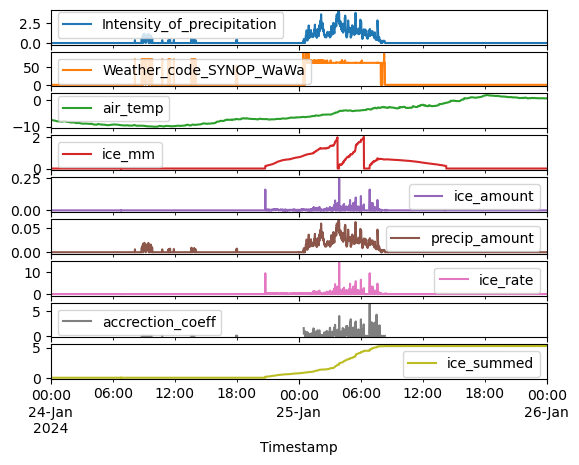

In [26]:
 analysis_1T_df[start_event:end_event].plot(subplots = True)

/tmp/larocque-jacta/2019059/ipykernel_2132752/351143032.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(columns))


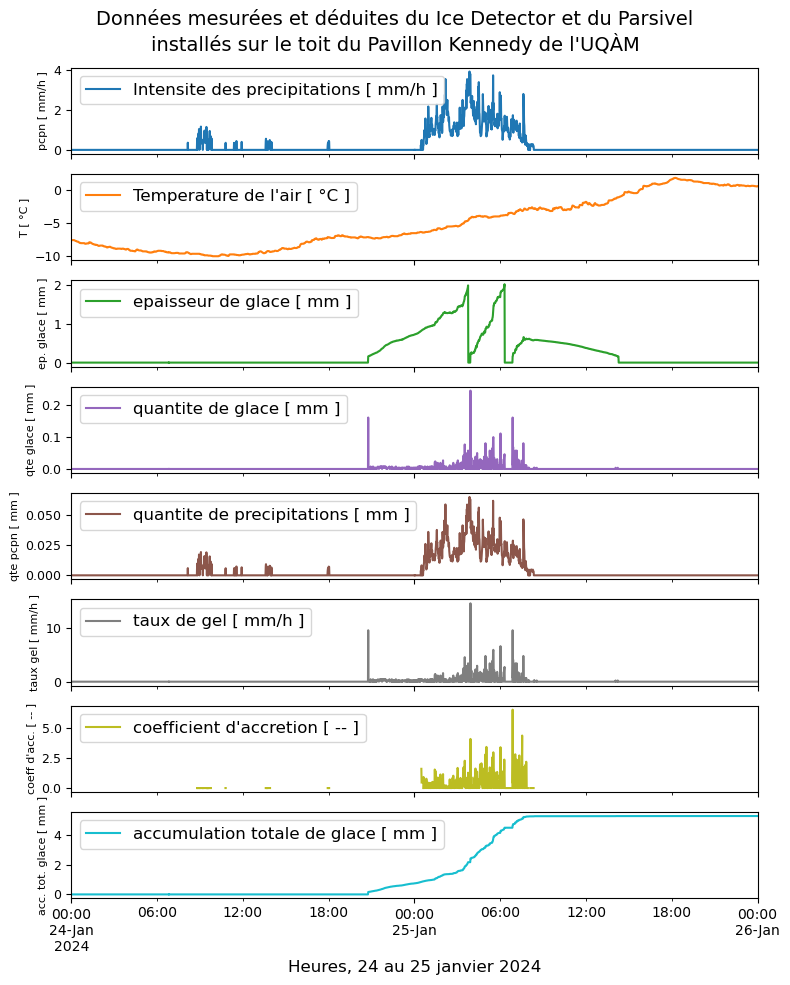

In [27]:
fig_df = analysis_1T_df[start_event:end_event][[c for c in analysis_1T_df.columns if "WaWa" not in c]]

columns = fig_df.columns[:]

legends = [ "Intensite des precipitations [ mm/h ]", # Intensity of pcpn
            "Temperature de l'air [ °C ]", # air temp
            "epaisseur de glace [ mm ]", # ice_mm
            "quantite de glace [ mm ]", # ice_amount
            "quantite de precipitations [ mm ]", # precip_amount
            "taux de gel [ mm/h ]", # ice_rate
            "coefficient d'accretion [ -- ]", # accretion coefficient
            "accumulation totale de glace [ mm ]"] # ice_summed

ylabels = [ "pcpn [ mm/h ]", # Intensity of pcpn
            "T [ °C ]", # air temp
            "ep. glace [ mm ]", # ice_mm
            "qte glace [ mm ]", # ice_amount
            "qte pcpn [ mm ]", # precip_amount
            "taux gel [ mm/h ]", # ice_rate
            "coeff d'acc. [ -- ]", # accretion coefficient
            "acc. tot. glace [ mm ]"] #ice_summed

# Colormap (tu peux changer pour 'tab10', 'Set2', 'Dark2', etc.)
colormap = cm.get_cmap('tab10', len(columns))
colors = [colormap(i) for i in range(len(columns))]

# Création des subplots manuellement
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 10), sharex=True)

fig.suptitle("Données mesurées et déduites du Ice Detector et du Parsivel\n"+\
             "installés sur le toit du Pavillon Kennedy de l'UQÀM", fontsize=14)

for i, (col, ylabel, legend_label) in enumerate(zip(columns, ylabels, legends)):
    ax = axes[i]
    fig_df[col].plot(ax=ax, label=legend_label, color = colors[i])
    ax.set_ylabel(ylabel, fontsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.legend(loc='upper left', fontsize=12)
              
ax.set_xlabel("Heures, 24 au 25 janvier 2024", fontsize = 12)
          
    

plt.tight_layout()
plt.savefig(fig_output_path + "PK_UQAM_DATA_jan24_2024.png") #MODIFIER
plt.show()

### Données moyennes du réseau sygivre et des relations statistiques pour le calcul de l'accumulation de glace

In [28]:
# Colonnes d’intérêt
cols = [col for col in hertel_df.columns if col.endswith("mm")]

chenier_filtered = chenier_df.loc[start_event:end_event, cols]
hertel_filtered = hertel_df.loc[start_event:end_event, cols]


In [29]:
sygivre_AverageOutput_df = (chenier_filtered + hertel_filtered) / 2


#### Analyse, étapes 3a à 3c

In [30]:
sygivre_AverageOutput_df['FzRa_average'] = sygivre_AverageOutput_df[[ col for col in sygivre_AverageOutput_df.columns if ("FzRa" in col) and ("RAJ" not in col)]].mean(axis=1)

In [31]:
sygivre_AverageOutput_df['Rime_average'] = sygivre_AverageOutput_df[[col for col in sygivre_AverageOutput_df.columns if "Rime" in col]].mean(axis=1)

In [32]:
sygivre_AverageOutput_df['acc_average']=sygivre_AverageOutput_df[cols].mean(axis=1)

In [33]:
sygivre_AverageOutput_df.columns

Index(['R35_FzRa_0mm', 'R12_FzRa_0mm', 'R315_FzRa_0mm', 'R35_min_Rime_0mm',
       'R12_min_Rime_0mm', 'R315_min_Rime_0mm', 'R35_max_Rime_0mm',
       'R12_max_Rime_0mm', 'R315_max_Rime_0mm', 'ACC_RAJ_FzRa_0mm',
       'FzRa_average', 'Rime_average', 'acc_average'],
      dtype='object')

#### Analyse, étapes 4a à 4d

In [34]:
analysis_1T_df.columns

Index(['Intensity_of_precipitation', 'Weather_code_SYNOP_WaWa', 'air_temp',
       'ice_mm', 'ice_amount', 'precip_amount', 'ice_rate', 'accrection_coeff',
       'ice_summed'],
      dtype='object')

In [35]:
# Accumulations en fonction du taux de précipitation moyen aux 10 min, disdromètre

analysis_10T_df=analysis_1T_df[
    ['Intensity_of_precipitation','ice_amount']
].resample('10min').agg({
    'Intensity_of_precipitation':'mean',
    'ice_amount':'sum',
    
})

In [36]:
analysis_10T_df = analysis_10T_df[start_event:end_event].copy()

In [37]:
analysis_10T_df['ice_summed'] = analysis_10T_df.ice_amount.cumsum()

In [38]:
# analysis_10T_df

In [39]:
# Gestion des données du disdromètre pour avoir la vitesse et la taille de chute moyens

data_bins = df_Parsivel[start_event:end_event].iloc[:,14::].to_numpy()
data_bins[data_bins == 0] = np.nan
n_times = data_bins.shape[0]

data_array = data_bins.reshape(n_times, 32, 32)

Dbins = np.array(DbiFS)
vTbins = np.array(vTbiFS)

# --- Moyenne des dimensions (somme sur vitesses → axe=1)
dim_counts = np.nansum(data_array, axis=1)  # (n_times, 32 diamètres)
weighted_dim = np.nansum(dim_counts * Dbins, axis=1)
total_dim = np.nansum(dim_counts, axis=1)
D_moyenne = weighted_dim / total_dim
D_moyenne[total_dim == 0] = np.nan

# --- Moyenne des vitesses (somme sur diamètres → axe=2)
vit_counts = np.nansum(data_array, axis=2)  # (n_times, 32 vitesses)
weighted_vit = np.nansum(vit_counts * vTbins, axis=1)
total_vit = np.nansum(vit_counts, axis=1)
V_moyenne = weighted_vit / total_vit
V_moyenne[total_vit == 0] = np.nan

# Index temporel
X = df_Parsivel[start_event:end_event].index

# Dataframe de sortie (index = temps, col1 = Vmoy, col2 = Dmoy)
df_parsivel_stats = pd.DataFrame({
    'Vitesse_moyenne': V_moyenne,
    'Dimension_moyenne': D_moyenne
}, index=X).resample('10min').mean()

analysis_10T_df['Vit_moy'] = df_parsivel_stats['Vitesse_moyenne'].copy()
analysis_10T_df['Dim_moy'] = df_parsivel_stats['Dimension_moyenne'].copy()

/tmp/larocque-jacta/2019059/ipykernel_2132752/3103152379.py:16: RuntimeWarning: invalid value encountered in divide
  D_moyenne = weighted_dim / total_dim
/tmp/larocque-jacta/2019059/ipykernel_2132752/3103152379.py:23: RuntimeWarning: invalid value encountered in divide
  V_moyenne = weighted_vit / total_vit


In [40]:
analysis_10T_df

,Intensity_of_precipitation,ice_amount,ice_summed,Vit_moy,Dim_moy
Timestamp,,,,,
2024-01-24 00:00:00,0.0,0.0,0.000000,NaN,NaN
2024-01-24 00:10:00,0.0,0.0,0.000000,NaN,NaN
2024-01-24 00:20:00,0.0,0.0,0.000000,NaN,NaN
2024-01-24 00:30:00,0.0,0.0,0.000000,NaN,NaN
2024-01-24 00:40:00,0.0,0.0,0.000000,NaN,NaN
...,...,...,...,...,...
2024-01-25 23:20:00,0.0,0.0,5.257758,NaN,NaN
2024-01-25 23:30:00,0.0,0.0,5.257758,NaN,NaN
2024-01-25 23:40:00,0.0,0.0,5.257758,NaN,NaN


#### Analyse, étape 6

In [41]:
# Rééchantillonnage aux 10 minutes
df_10min = sygivre_AverageOutput_df.resample('10min').asfreq()

# On interpole linéairement les valeurs manquantes
sygivre_10min_interpolated = df_10min.interpolate(method='linear')


In [42]:
analysis_10T_df['acc_diff'] = analysis_10T_df[start_event:end_event]["ice_summed"] - sygivre_10min_interpolated["acc_average"]

## TIME SERIES

### DATAFRAMES À UTILISER : (disponibles)
- tous les 'station_df'
- sygivre_AverageOutput_df
- sygivre_10min_interpolated
- analysis_1T_df
- analysis_10T_df


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

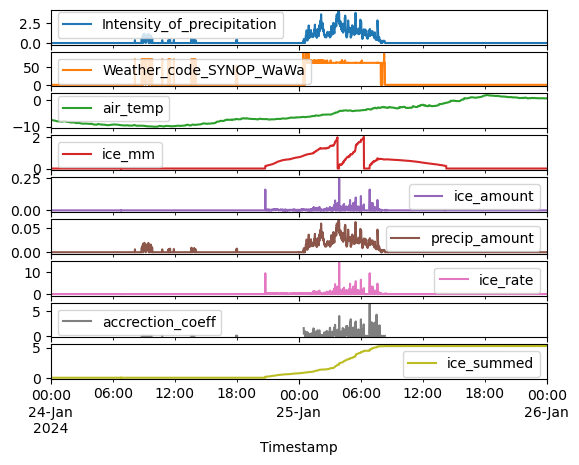

In [43]:
analysis_1T_df[start_event:end_event].plot(subplots=True)

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

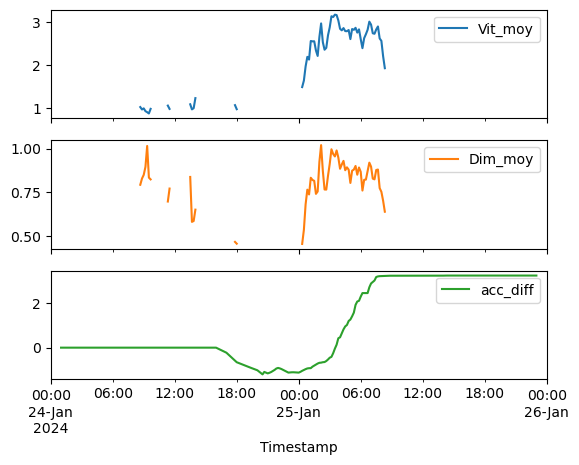

In [44]:
analysis_10T_df[['Vit_moy','Dim_moy','acc_diff']].plot(subplots=True)

/tmp/larocque-jacta/2019059/ipykernel_2132752/313650397.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(columns))


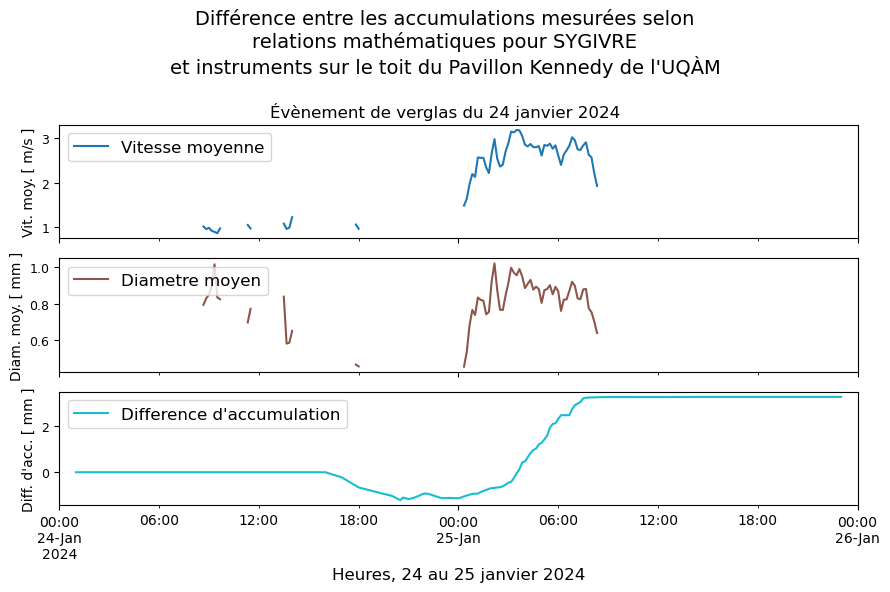

In [45]:
df = analysis_10T_df[['Vit_moy','Dim_moy','acc_diff']]
df.index = pd.to_datetime(df.index)

# Noms des colonnes
columns = df.columns

# Y-labels (unités)
ylabels = [
    "Vit. moy. [ m/s ]",
    "Diam. moy. [ mm ]",
    "Diff. d'acc. [ mm ]"
]

# Légendes
legends = [
    "Vitesse moyenne",
    "Diametre moyen",
    "Difference d'accumulation"
]

# Couleurs différentes
colormap = cm.get_cmap('tab10', len(columns))
colors = [colormap(i) for i in range(len(columns))]

# Créer les subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 6), sharex=True)
fig.suptitle("Différence entre les accumulations mesurées selon\n"+\
                "relations mathématiques pour SYGIVRE\n"+\
             "et instruments sur le toit du Pavillon Kennedy de l'UQÀM", fontsize=14)

fig.text(0.5,0.8, "Évènement de verglas du 24 janvier 2024", ha='center', fontsize=12) # MODIFIER

# Tracer chaque variable
for i, (col, ylabel, legend_label) in enumerate(zip(columns, ylabels, legends)):
    ax = axes[i]
    df[col].plot(ax=ax, label=legend_label, color=colors[i])
    ax.set_ylabel(ylabel, fontsize=10)
    ax.legend(loc='upper left', fontsize=12)
    ax.tick_params(axis='y', labelsize=9)

ax.set_xlabel("Heures, 24 au 25 janvier 2024", fontsize = 12) # MODIFIER

# Mise en page
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(fig_output_path+"PK_UQAM-SYGIVRE-DIFF_jan24_2024.png") # MODIFIER
plt.show()
 

<Axes: xlabel='timestamp'>

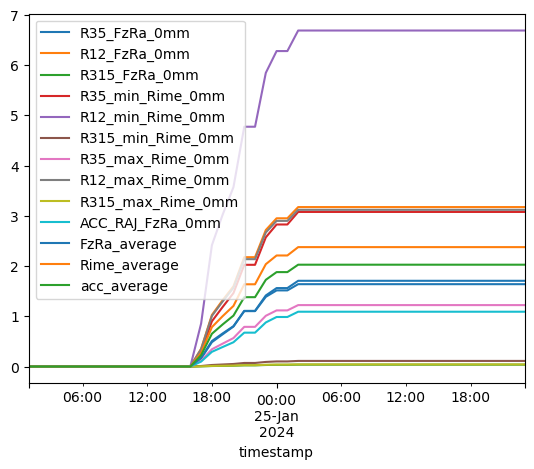

In [46]:
sygivre_AverageOutput_df.plot()

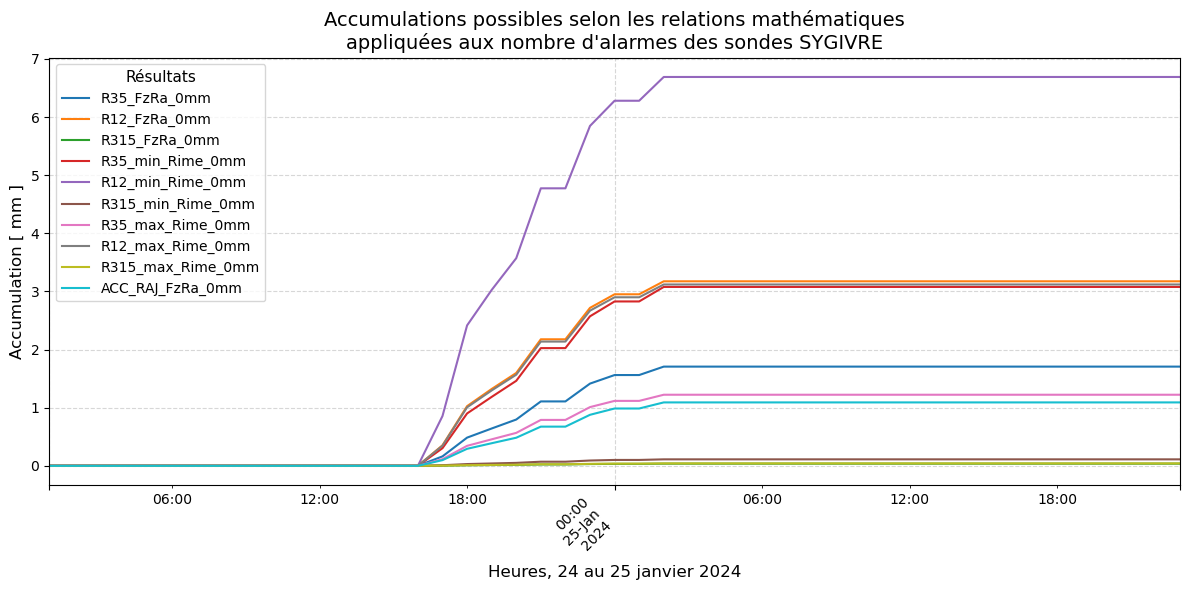

In [47]:
#RÉSULTATS DES RELATIONS MATHÉMATIQUES SUR SYGIVRE

fig, ax = plt.subplots(figsize=(12, 6))

# Tracé principal
sygivre_AverageOutput_df[[c for c in sygivre_AverageOutput_df.columns if 'average' not in c]].plot(ax=ax)

# Titre principal
ax.set_title("Accumulations possibles selon les relations mathématiques\n"+\
             "appliquées aux nombre d'alarmes des sondes SYGIVRE", fontsize=14)

# Étiquettes des axes
ax.set_xlabel("Heures, 24 au 25 janvier 2024", fontsize=12) # MODIFIER
ax.set_ylabel("Accumulation [ mm ]", fontsize=12)  # Remplace par l’unité réelle

# Formatage de l’axe X pour afficher date et heure
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %H:%M"))
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Légende
ax.legend(title="Résultats", fontsize=10, title_fontsize=11)

# Grille optionnelle
ax.grid(True, linestyle='--', alpha=0.5)

# Ajustement de l’espace
plt.tight_layout()

# Sauvegarde
plt.savefig(fig_output_path+"PK_SYGIVRE-EQ-RES_jan24_2024.png", dpi=300) # MODIFIER

# Affichage
plt.show()

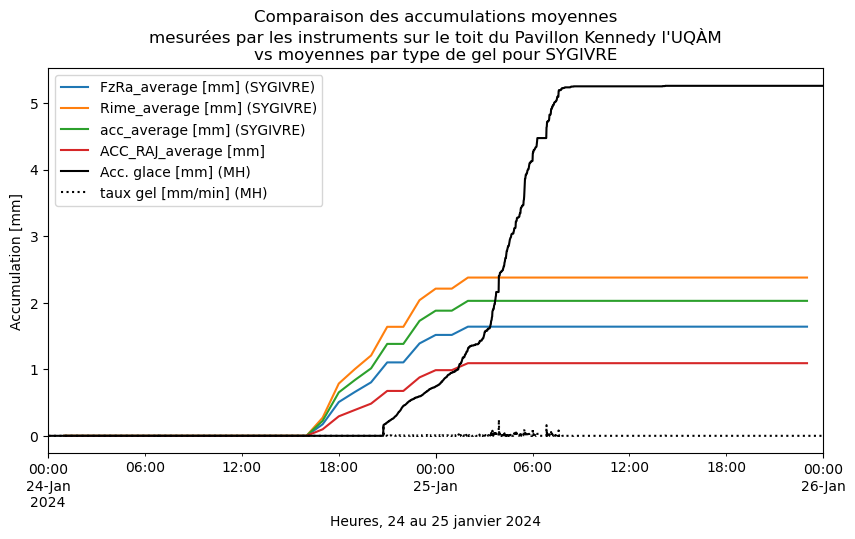

In [48]:
# Créer une figure
plt.figure(figsize=(10, 5))

for col in [c for c in sygivre_AverageOutput_df.columns if "average" in c]:
    sygivre_AverageOutput_df.loc[start_event:end_event, col].plot(ax=plt.gca(), label=col + " [mm] (SYGIVRE)")

sygivre_AverageOutput_df.loc[start_event:end_event, 'ACC_RAJ_FzRa_0mm'].plot(ax=plt.gca(), label='ACC_RAJ_average' + " [mm] ")

# Tracer la courbe "ice_amount" de analysis_1T_df par-dessus
analysis_1T_df[start_event:end_event]['ice_amount'].cumsum().plot(ax=plt.gca(), color='black', linestyle='-', label='Acc. glace [mm] (MH)')

# Tracer la courbe "ice_amount" de analysis_1T_df par-dessus
analysis_1T_df[start_event:end_event]['ice_amount'].plot(ax=plt.gca(), color='black', linestyle='dotted', label='taux gel [mm/min] (MH)')

# Ajouter légende, titre, axes si tu veux
plt.legend()
plt.title("Comparaison des accumulations moyennes\nmesurées par les instruments sur le toit du Pavillon Kennedy l'UQÀM\nvs moyennes par type de gel pour SYGIVRE")
plt.xlabel("Heures, 24 au 25 janvier 2024")
plt.ylabel("Accumulation [mm]")

plt.savefig(fig_output_path+"PK_COMPARE_ACC_jan24_2024.png")
# Afficher le graphique
plt.show()

In [49]:
# Pour l'analyse, le dataframe utilisé doit avoir les colonnes "Dim_moy", "Vit_moy" et "acc_diff"

analysis_10T_clean = analysis_10T_df.dropna().copy()

# --- Corrélations
pearson_dim = stats.pearsonr(analysis_10T_clean["Dim_moy"], analysis_10T_clean["acc_diff"])
spearman_dim = stats.spearmanr(analysis_10T_clean["Dim_moy"], analysis_10T_clean["acc_diff"])

pearson_vit = stats.pearsonr(analysis_10T_clean["Vit_moy"], analysis_10T_clean["acc_diff"])
spearman_vit = stats.spearmanr(analysis_10T_clean["Vit_moy"], analysis_10T_clean["acc_diff"])

print("\n--- Corrélations ---")
print(f"Pearson DimMoy: r = {pearson_dim[0]:.3f}, p = {pearson_dim[1]:.3f}")
print(f"Spearman DimMoy: r = {spearman_dim.correlation:.3f}, p = {spearman_dim.pvalue:.3f}")
print(f"Pearson VitMoy: r = {pearson_vit[0]:.3f}, p = {pearson_vit[1]:.3f}")
print(f"Spearman VitMoy: r = {spearman_vit.correlation:.3f}, p = {spearman_vit.pvalue:.3f}")

# --- Catégoriser par quantiles pour ANOVA
analysis_10T_clean["Dim_class"] = pd.qcut(analysis_10T_clean["Dim_moy"], q=4, labels=False)
analysis_10T_clean["Vit_class"] = pd.qcut(analysis_10T_clean["Vit_moy"], q=4, labels=False)

anova_dim = stats.f_oneway(*[
    analysis_10T_clean.loc[analysis_10T_clean["Dim_class"] == i, "acc_diff"]
    for i in range(4)
])
anova_vit = stats.f_oneway(*[
    analysis_10T_clean.loc[analysis_10T_clean["Vit_class"] == i, "acc_diff"]
    for i in range(4)
])

print("\n--- ANOVA par quantiles ---")
print(f"DimMoy : F = {anova_dim.statistic:.2f}, p = {anova_dim.pvalue:.3f}")
print(f"VitMoy : F = {anova_vit.statistic:.2f}, p = {anova_vit.pvalue:.3f}")

# --- Régression linéaire multiple

X = analysis_10T_clean[["Dim_moy", "Vit_moy"]].values
y = analysis_10T_clean["acc_diff"].values
model = LinearRegression().fit(X, y)

print("\n--- Régression linéaire multiple ---")
print(f"R² = {model.score(X, y):.3f}")
print(f"Coefficients : DimMoy = {model.coef_[0]:.3f}, VitMoy = {model.coef_[1]:.3f}")
print(f"Intercept = {model.intercept_:.3f}")

# Régression linéaire multiple avec p-values
X = analysis_10T_clean[["Dim_moy", "Vit_moy"]]
y = analysis_10T_clean["acc_diff"]

# Ajoute une constante (intercept)
X = sm.add_constant(X)

# Fit du modèle
model = sm.OLS(y, X).fit()

# Résumé complet du modèle avec p-values
print("\n--- Régression linéaire multiple (avec p-values) ---")
print(model.summary())


--- Corrélations ---
Pearson DimMoy: r = 0.196, p = 0.111
Spearman DimMoy: r = 0.222, p = 0.071
Pearson VitMoy: r = 0.382, p = 0.001
Spearman VitMoy: r = 0.332, p = 0.006

--- ANOVA par quantiles ---
DimMoy : F = 1.15, p = 0.335
VitMoy : F = 9.51, p = 0.000

--- Régression linéaire multiple ---
R² = 0.147
Coefficients : DimMoy = -0.502, VitMoy = 0.726
Intercept = -0.537

--- Régression linéaire multiple (avec p-values) ---
                            OLS Regression Results                            
Dep. Variable:               acc_diff   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5.535
Date:                Thu, 07 Aug 2025   Prob (F-statistic):            0.00606
Time:                        12:00:42   Log-Likelihood:                -111.98
No. Observations:                  67   AIC:                             230.0
Df Residuals:      

## FIGURES - DISDROMETER

In [50]:
# # Disdrometer figures from FRZN events

# # Subset of data
# spectrum = df_Parsivel[start_event:end_event].iloc[:, 14::]
# resample_data = spectrum.sum(axis = 0)

# resample_data = resample_data.replace(0, np.nan)
# b = resample_data.values.reshape(32,32)
# b = np.ma.masked_where(np.isnan(b),b)

# plt.style.use('seaborn-v0_8-ticks')
# fig, ax = plt.subplots(1,1, figsize=(7,3.5), dpi=300, facecolor='white')
# X,Y = np.meshgrid(DbiFS,vTbiFS)
# pc = ax.pcolormesh(X,Y,np.log10(b) , alpha=0.75, cmap='rainbow', vmin=0, vmax=4.5)
# yo2 = fig.colorbar(pc,ticks=[0,1,2,3,4], fraction=0.02, pad=0.01, label='Particle count')
# yo2.ax.set_yticklabels([r'$1$',r'$10$',r'$100$',r'$1000$', r'$10000$'])

# #pc = ax.pcolormesh(X,Y,b, alpha=.75, cmap="rainbow")
# #fig.colorbar(pc, orientation="vertical", fraction=0.02, pad=0.01, label='Partical count')
# #ax.scatter(x=Dmoy,y=Vmoy, s=200, marker='+', color="red" )
# ax.set_xlim(0,20)
# ax.set_ylim(0,10)
# plt.plot(dfit,vrain(dfit),'g',label=u"Rain", linewidth=1.)
# plt.plot(dfit,vlumpg_g(dfit), 'black', label=u"Snow Pellets", linewidth=1., linestyle='-')
# plt.plot(dfit,vwet(dfit),'r',label=u"Wet Snow", linewidth=1.)
# plt.plot(dfit,vdry(dfit), 'b', label=u"Dry Snow", linewidth=1.)

# for vT in vTbiFS:
#     plt.axhline(y=vT, xmin=0., xmax=10, linewidth=0.2, color = 'k')   
# for D in DbiFS:
#     plt.axvline(x=D, ymin=0.0, ymax = 18, linewidth=0.2, color='k')

# plt.xticks([2,4,6,8,10,12,14,16,18,20])

# plt.axis((0,DbiFS[30],0,vTbiFS[28]))
# ax.set_xlim([0,5])
# ax.set_ylim([0,10])
# plt.xlabel('Diameter (mm)')
# plt.ylabel('Fall Speed (m s$^{-1}$)')
# fig1 = plt.gcf()
# plt.legend(loc='upper right', fontsize=8)
# plt.title('UQAM PK', loc='left', fontsize=8)
# plt.title(f'Valid: {start_event} - {end_event} ', loc='right', fontsize=8)